In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import get_earth, Helioprojective
import astropy.table

from fiasco.io import Parser

from mocksipipeline.physics.spectral import get_spectral_tables
from mocksipipeline.detector.component import compute_flux_point_source, dem_table_to_ndcube, blur_spectra
from mocksipipeline.detector.response import get_all_dispersed_channels

# MOXSI Spectra from Point Sources

This notebook contains spectra for the most up to date response model for two different DEM models: active region and flare.

In [2]:
earth_observer = get_earth(time='2020-01-01 12:00:00')

In [3]:
chianti_dir = '/Users/wtbarnes/ssw/packages/chianti/dbase/'
dem_ar = dem_table_to_ndcube(Parser('active_region.dem', ascii_dbase_root=chianti_dir).parse())
dem_flare = dem_table_to_ndcube(Parser('flare_ext.dem', ascii_dbase_root=chianti_dir).parse())

In [4]:
spec_tables = get_spectral_tables()

In [5]:
all_channels = get_all_dispersed_channels()

In [6]:
roll_angle = 0 * u.deg

In [7]:
blur = 40 * u.arcsec / all_channels[0].resolution[0] * all_channels[0].spectral_resolution

In [8]:
line_list = astropy.table.QTable.read('../data/moxsi-line-list.asdf')

In [9]:
ar_line_labels = line_list[line_list['intensity_scaled (coronal)_active_region']>0.05]
ar_line_labels = ar_line_labels[['ion name', 'wavelength', 'ion id']]

In [10]:
flare_line_labels = line_list[line_list['intensity_scaled (coronal)_flare_ext']>0.05]
flare_line_labels = flare_line_labels[['ion name', 'wavelength', 'ion id']]

In [11]:
def annotate_lines(axis, channels, location, line_list, y_pos=0, **kwargs):
    for i, chan in enumerate(channels):
        line_pos, _, _ = chan.get_wcs(location.observer, **kwargs).world_to_pixel(location, line_list['wavelength'])
        color = f'C{i}'
        for pos, row in zip(line_pos, line_list):
            bump_up = chan.spectral_order%2 == 0
            bump = 30
            text_ypos = 360
            axis.annotate(
                f'{row["ion name"]}, {row["wavelength"].to_string(format="latex_inline", precision=5)}',
                (pos, y_pos),
                xytext=(0, text_ypos+bump if bump_up else text_ypos),
                textcoords='offset points',
                rotation=90,
                color=color,
                horizontalalignment='center',
                verticalalignment='center',
                arrowprops=dict(color=color, arrowstyle='-', ls='--'),
            )

In [12]:
def plot_spectrum(dem, spectral_table, channels, location, line_list, y_lim, blur=None, log_y=True, **kwargs):
    flux = compute_flux_point_source(dem,
                                     spectral_table,
                                     location,
                                     blur=blur,
                                     electrons=False,
                                     include_gain=False,
                                     **kwargs)
    
    pix_grid = np.arange(0,2000,1)
    fig = plt.figure(figsize=(25,5))
    ax = fig.add_subplot()
    total = np.zeros(pix_grid.shape)
    for chan in channels:
        x_,_,_ = chan.get_wcs(location.observer, **kwargs).world_to_pixel(location, chan.wavelength)
        y = flux[f'order_{chan.spectral_order}'].data
        if blur:
            y = blur_spectra(y, blur, chan).data
        y_interp = interp1d(x_, y, kind='linear', bounds_error=False, fill_value=0)(pix_grid)
        total += y_interp
        ax.plot(pix_grid, y_interp, label=f'order={chan.spectral_order}')
    ax.plot(pix_grid, total, color='k', ls='-', label='total', alpha=0.75)
    annotate_lines(ax, channels, location, line_list, y_pos=y_lim[0], **kwargs)
    if log_y:
        ax.set_yscale('log')
    ax.set_xlim(850, 2000)
    ax.set_ylim(y_lim)
    ax.legend(loc=2)

## Flare at Disk Center

In [13]:
flare_center = SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec,
                        frame=Helioprojective(obstime=earth_observer.obstime, observer=earth_observer))

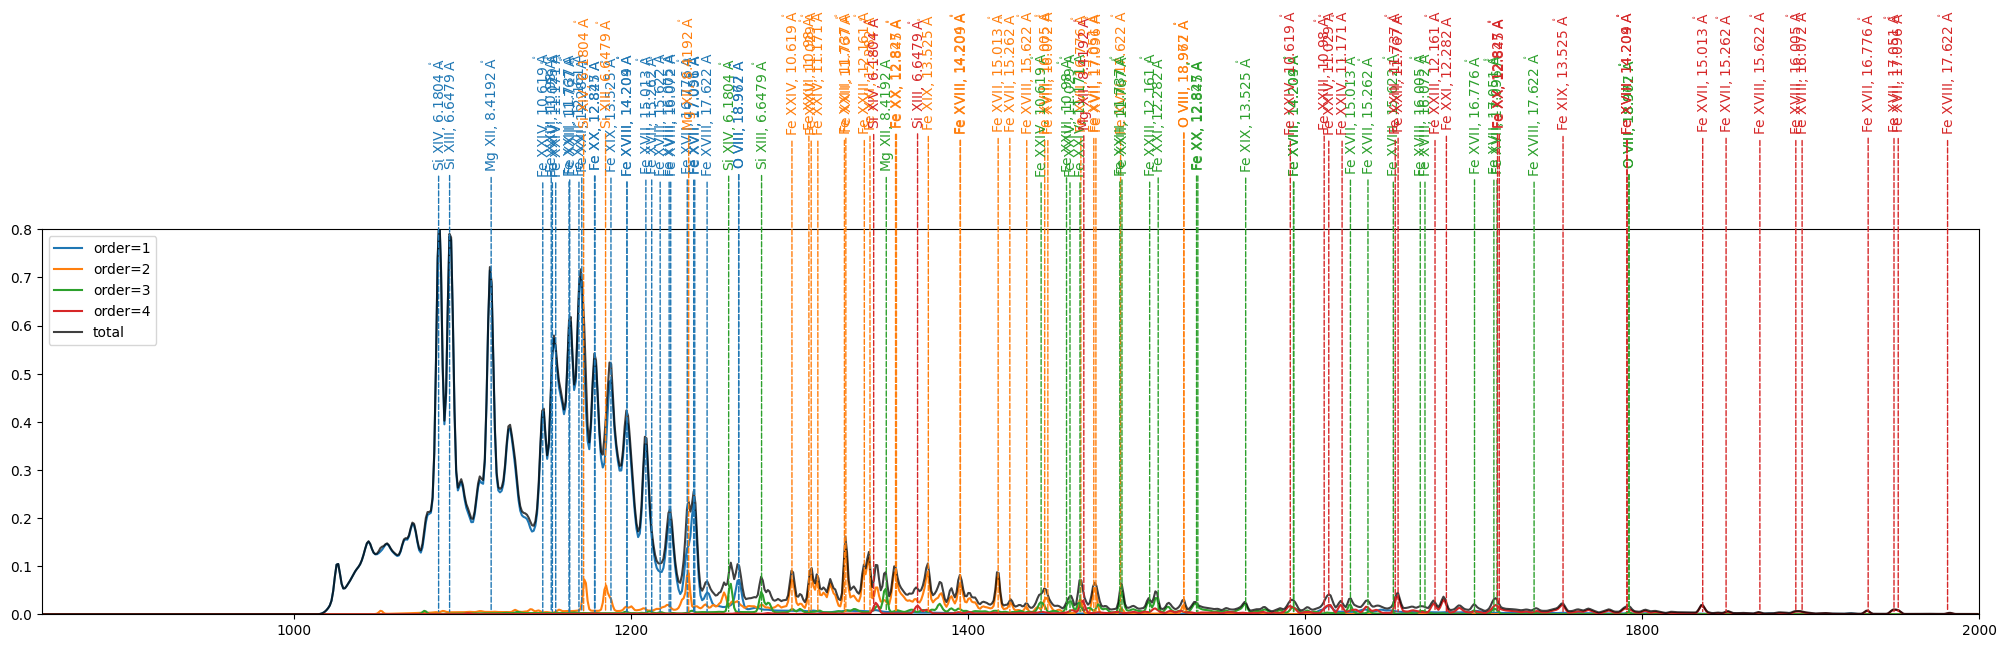

In [27]:
plot_spectrum(dem_flare,
              spec_tables['sun_coronal_1992_feldman_ext_all'],
              all_channels[5:],
              flare_center, 
              flare_line_labels, 
              (0, 0.8),
              blur=blur,
              log_y=False,
              roll_angle=roll_angle)

## AR at Disk Center

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


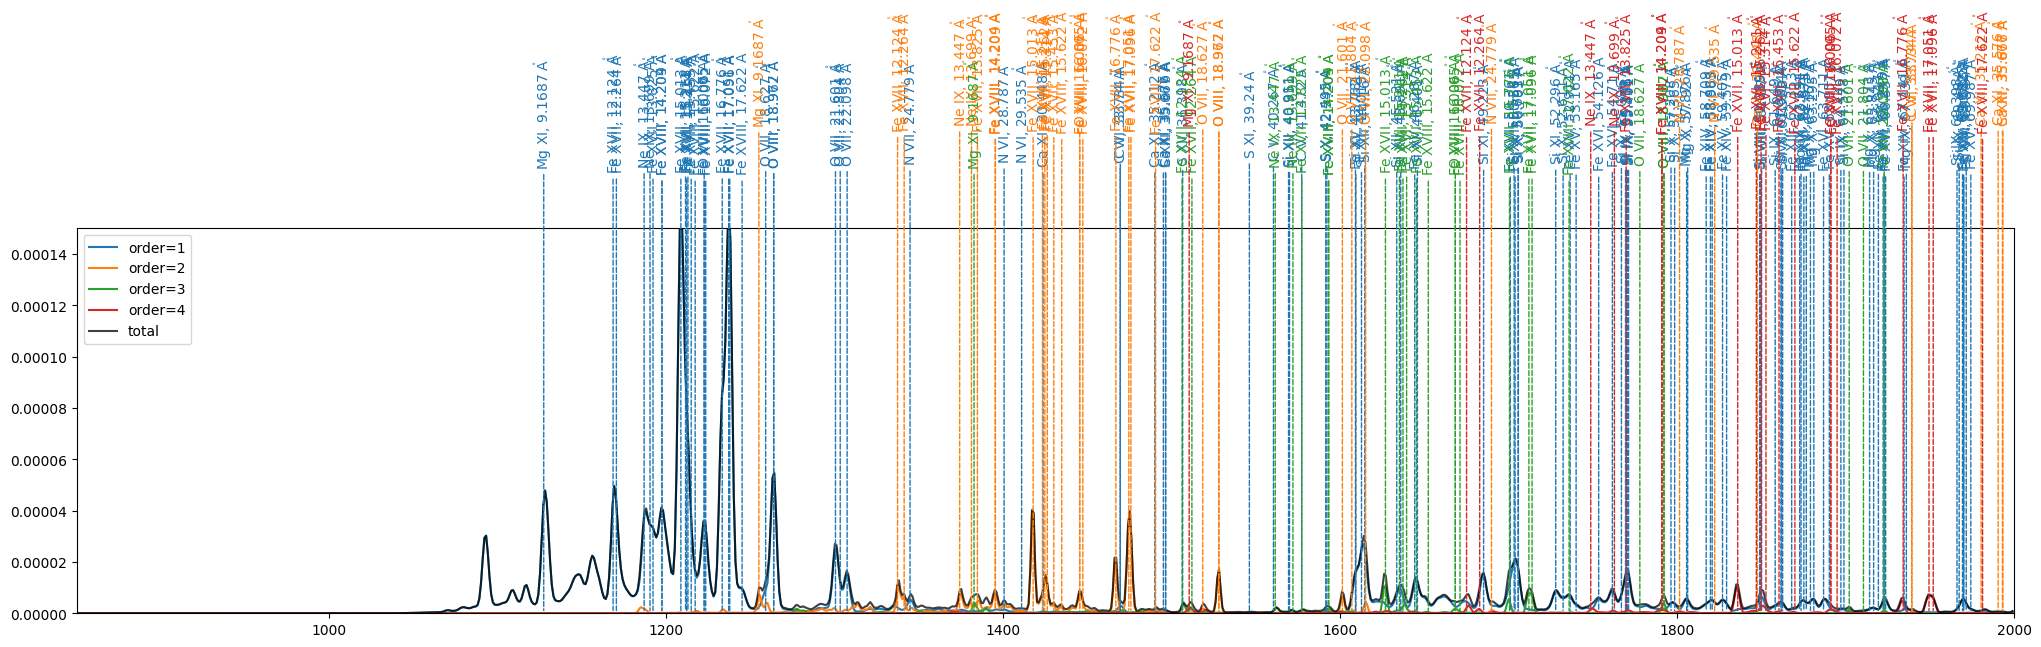

In [14]:
plot_spectrum(dem_ar,
              spec_tables['sun_coronal_1992_feldman_ext_all'],
              all_channels[5:],
              flare_center, 
              ar_line_labels,
              (0,1.5e-4),
              log_y=False,
              blur=blur,
              roll_angle=roll_angle)

## Flare at West Limb

In [29]:
flare_limb_west = SkyCoord(Tx=1000*u.arcsec, Ty=0*u.arcsec,
                     frame=Helioprojective(obstime=earth_observer.obstime, observer=earth_observer))

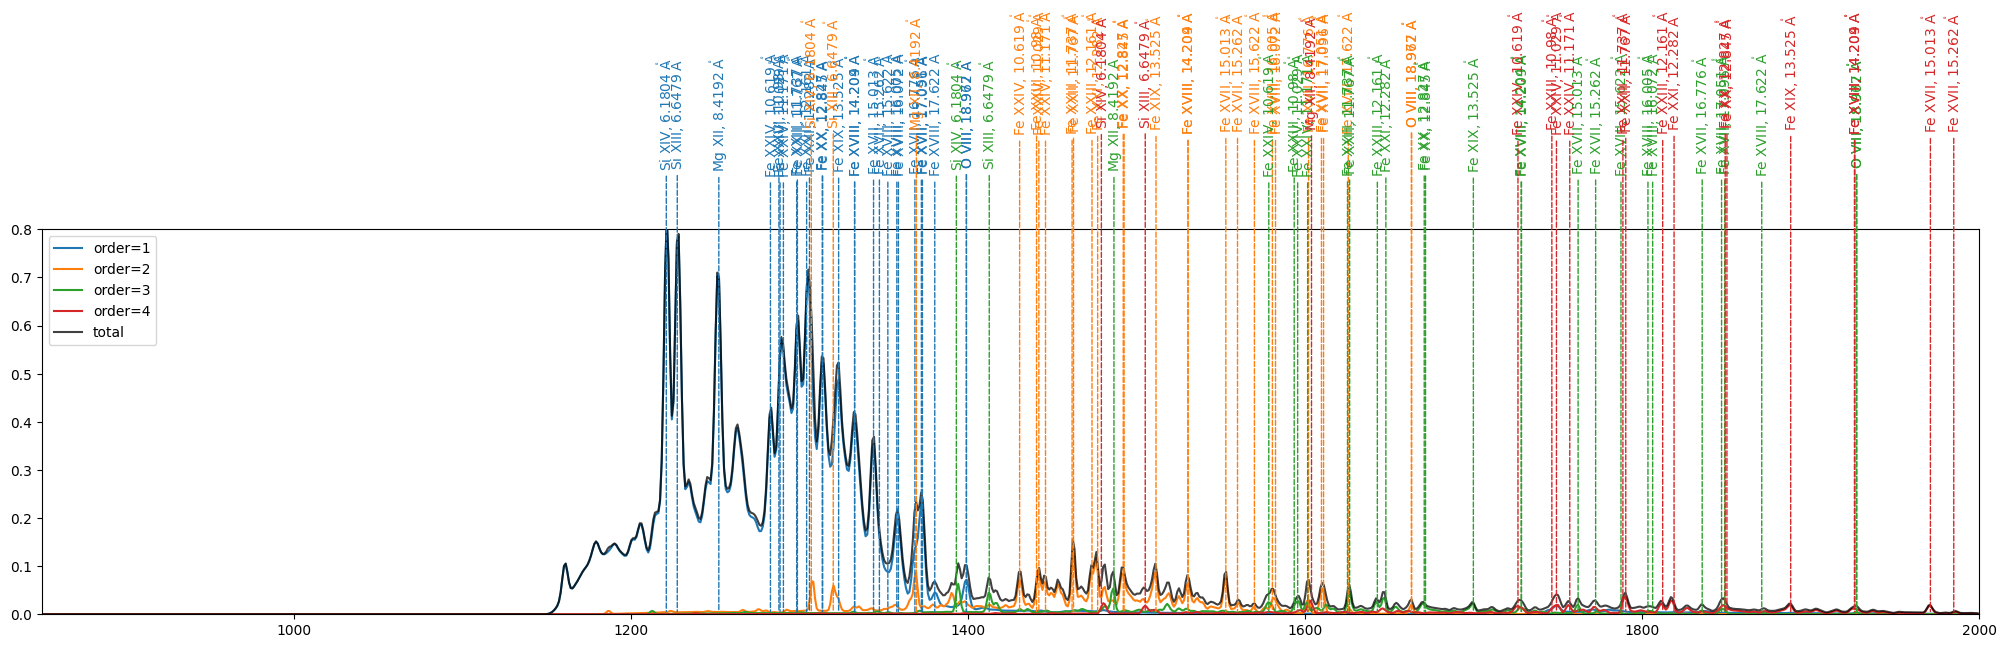

In [30]:
plot_spectrum(dem_flare, 
              spec_tables['sun_coronal_1992_feldman_ext_all'],
              all_channels[5:],
              flare_limb_west,
              flare_line_labels, 
              (0, 0.8),
              log_y=False,
              blur=blur,
              roll_angle=roll_angle)

## AR at West Limb

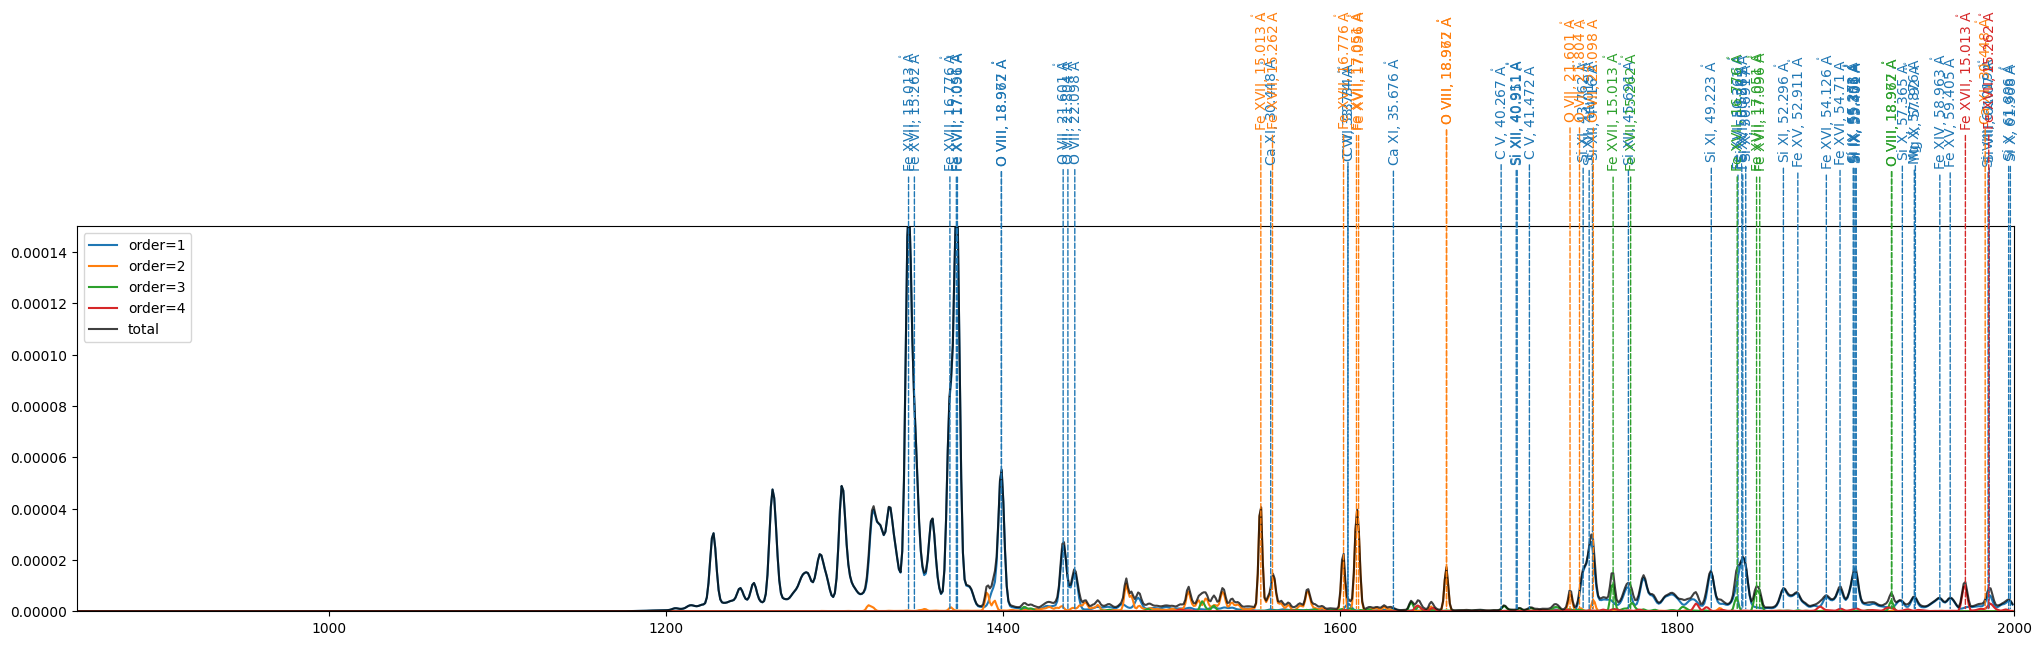

In [32]:
plot_spectrum(dem_ar, 
              spec_tables['sun_coronal_1992_feldman_ext_all'],
              all_channels[5:], 
              flare_limb_west, 
              ar_line_labels,
              (0,1.5e-4),
              log_y=False,
              blur=blur,
              roll_angle=roll_angle)

## Flare at East Limb

In [33]:
flare_limb_east = SkyCoord(Tx=-1000*u.arcsec, Ty=0*u.arcsec,
                     frame=Helioprojective(obstime=earth_observer.obstime, observer=earth_observer))

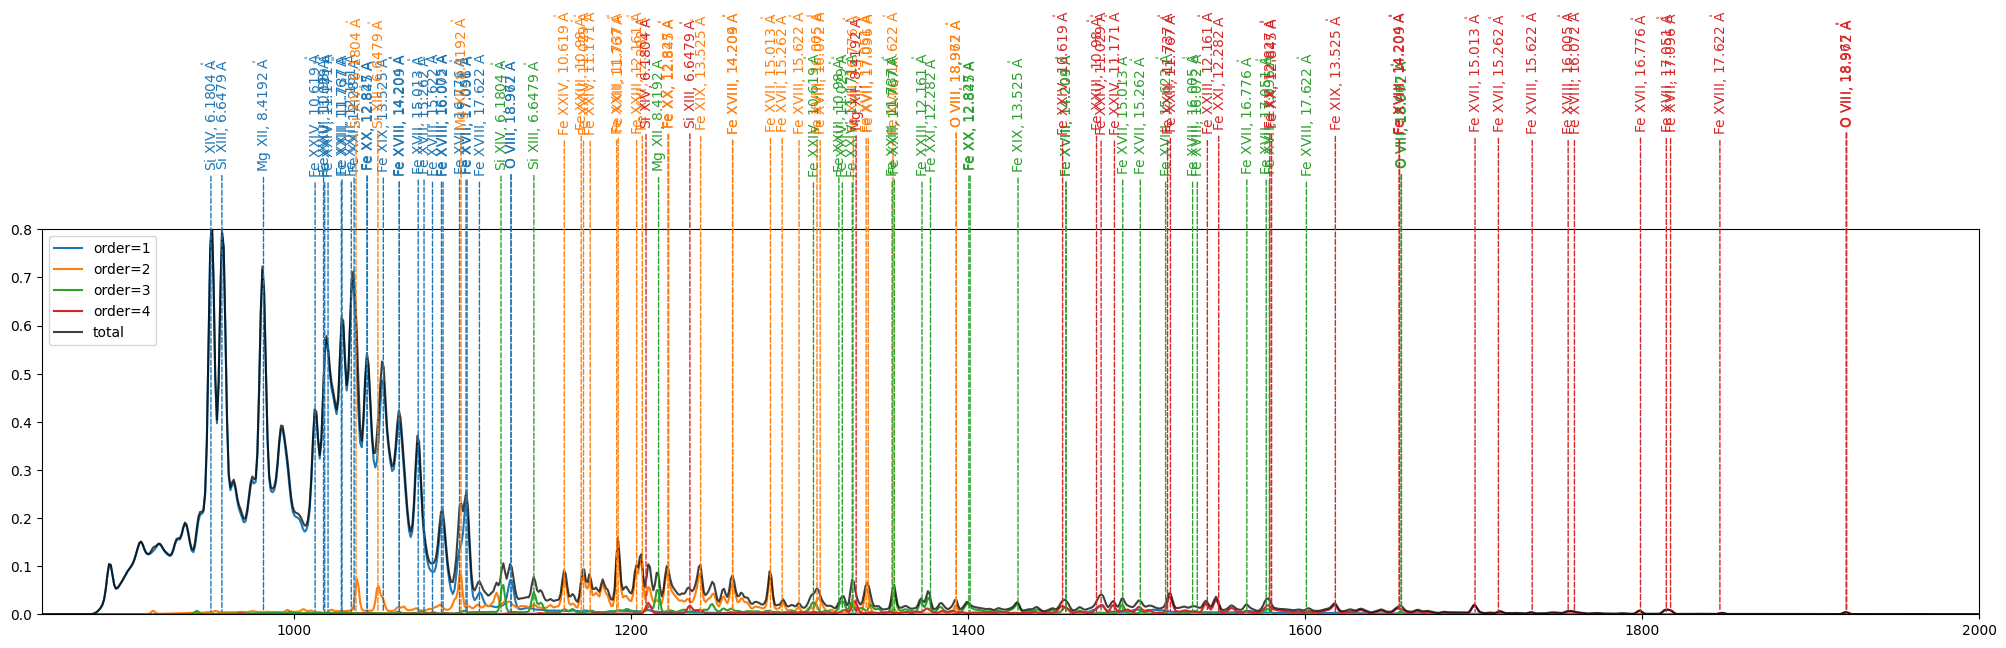

In [34]:
plot_spectrum(dem_flare,
              spec_tables['sun_coronal_1992_feldman_ext_all'],
              all_channels[5:],
              flare_limb_east,
              flare_line_labels,
              (0,0.8),
              log_y=False,
              blur=blur,
              roll_angle=roll_angle)

## AR at East Limb

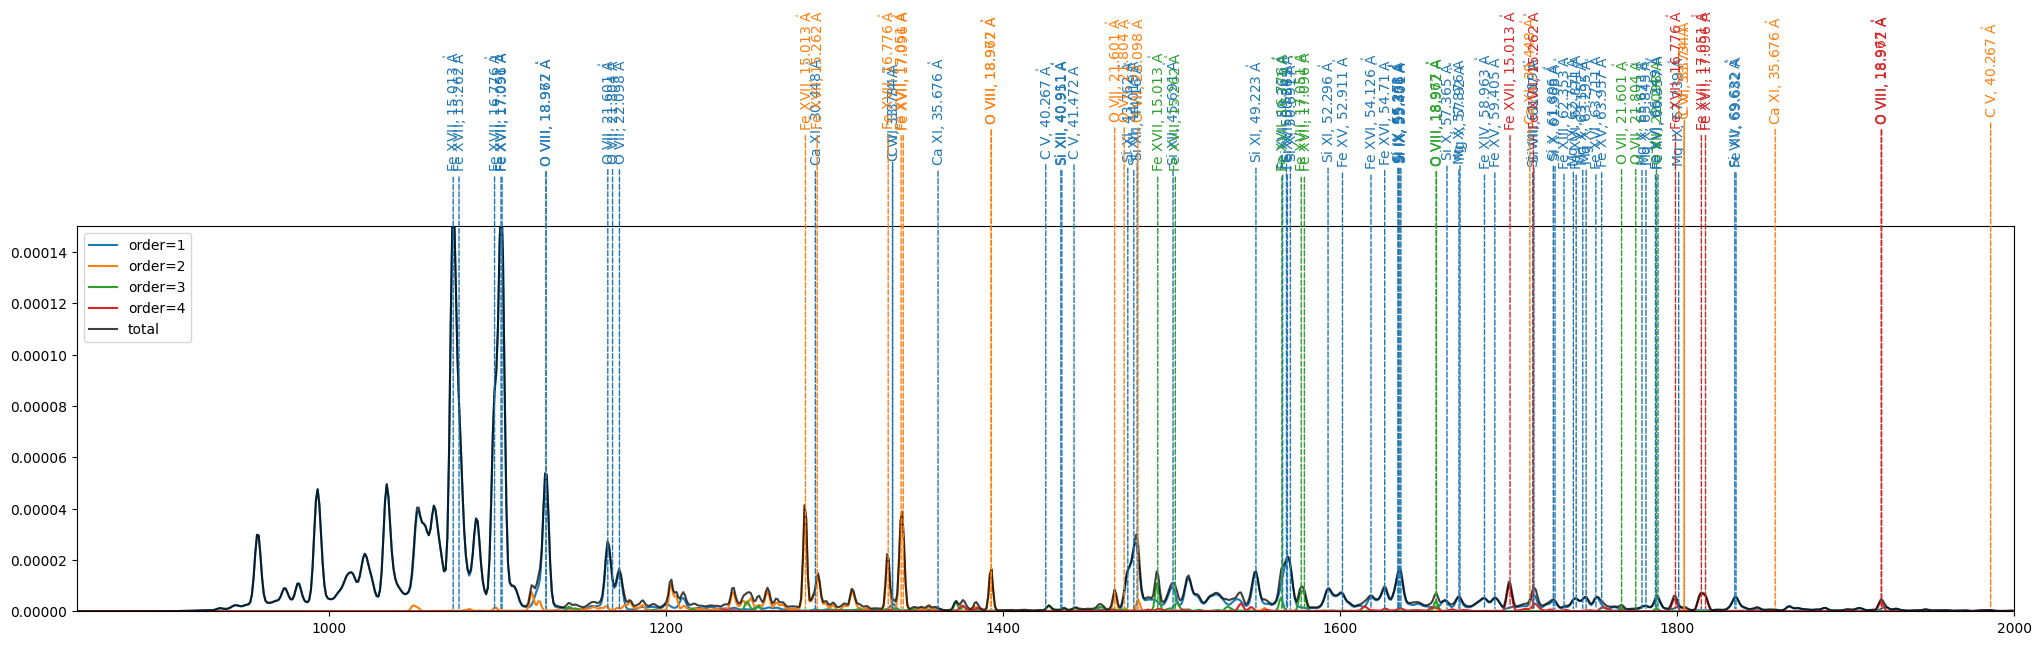

In [35]:
plot_spectrum(dem_ar,
              spec_tables['sun_coronal_1992_feldman_ext_all'],
              all_channels[5:], 
              flare_limb_east,
              ar_line_labels,
              (0,1.5e-4),
              log_y=False,
              blur=blur,
              roll_angle=roll_angle,)